In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd gdrive/My Drive/memedata/memes900k

/content/gdrive/My Drive/memedata/memes900k


In [4]:
!pip install transformers

     |████████████████████████████████| 1.3MB 11.1MB/s 
     |████████████████████████████████| 2.9MB 55.6MB/s 
     |████████████████████████████████| 890kB 53.9MB/s 
     |████████████████████████████████| 1.1MB 46.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ae82aad85940b2cdbcd1d2a38637206f031922cc12aebc7f85c1d01c6c71ccc7
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [38]:
#!/usr/bin/env python
# coding: utf-8
import torch
import random
from torch.utils.data import TensorDataset, random_split, WeightedRandomSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
import numpy as np
import time
import datetime
from transformers import get_linear_schedule_with_warmup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# cd drive/My Drive/CSCI566_project/memes900k

from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loading BERT tokenizer...


In [15]:
selected = set(['african children dancing', 'Angry Cat Meme', "Anchorman Birthday", "Annoying Gamer Kid", "Awkward Seal",
            "Black Kid", "burning house girl", "Desk Flip Rage Guy", "evil plan kid", "FU*CK THAT GUY", "Grumpy Cat 2",
            "Grumpy Cat Santa Hat", "high/drunk guy", "Joseph Ducreux", "Skeptical african kid", "so doge",
            "Success Kid", "Willy Wonka", "You shall not pass", "Y U No"])

x_train = []
y_train = []
# select from github dataset
with open("captions_train.txt") as file:
    for line in file.readlines():
        l, _, text = line.split('\t')
        if l.strip() in selected:
            y_train.append(l.strip())
            text = text.strip().replace('<sep>', ", ")
            x_train.append(text)
# x_train = x_train[:5000]
# y_train = y_train[:5000]

# select from https://imgflip.com/memetemplates
# with open("memes_output.txt") as file:
#     for line in file.readlines():
#         l, _, text = line.split('\t')
#         y_train.append(l.strip())
#         text = text.strip().replace(';', "[SEP]")
#         x_train.append(text)

templates_map = dict(zip(set(y_train), range(300)))
templates_map_reverse = dict(zip(range(300), set(y_train)))
len(templates_map)

y_train = [templates_map[i] for i in y_train if i]

x_test = []
y_test = []

with open("captions_test.txt") as file:
    for line in file.readlines():
        l, _, text = line.split('\t')
        if l in templates_map:
            y_test.append(templates_map[l])
            text = text.strip().replace('<sep>', ", ")
            # text = text.strip()
            x_test.append(text)

set(y_test)
# x_test = x_test[:2500]
# y_test = y_test[:2500]
x_val = []
y_val = []

with open("captions_val.txt") as file:
    for line in file.readlines():
        l, _, text = line.split('\t')
        if l in templates_map:
            y_val.append(templates_map[l])
            text = text.strip().replace('<sep>', ", ")
            # text = text.strip()
            x_val.append(text)
# x_val = x_val[:1000]
# y_val = y_val[:1000]
set(y_val)

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in x_train:
    encoded_dict = tokenizer.encode_plus(
        sent,  # Sentence to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=50,  # Pad & truncate all sentences.
        pad_to_max_length=True,
        return_attention_mask=True,  # Construct attn. masks.
        return_tensors='pt',  # Return pytorch tensors.
    )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

input_vals = []
attention_masks_val = []
# For every sentence...
for sent in x_val:
    encoded_dict = tokenizer.encode_plus(
        sent,  # Sentence to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=50,  # Pad & truncate all sentences.
        pad_to_max_length=True,
        return_attention_mask=True,  # Construct attn. masks.
        return_tensors='pt',  # Return pytorch tensors.
    )

    # Add the encoded sentence to the list.
    input_vals.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_val.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_vals = torch.cat(input_vals, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)

print('Original: ', x_train[3])
print('Token IDs:', input_ids[3])

# Create a 85-15 train-validation split proportional to number of classes.

# input_train,input_val,mask_train,mask_val,label_train,label_val = train_test_split(input_ids, attention_masks, torch.tensor(y_train), test_size=0.15, stratify=torch.tensor(y_train))
# train_dataset = TensorDataset(input_train, mask_train, label_train)
# val_dataset = TensorDataset(input_val, mask_val, label_val)
train_dataset = TensorDataset(input_ids, attention_masks, torch.tensor(y_train))
val_dataset = TensorDataset(input_vals, attention_masks_val, torch.tensor(y_val))
# Checking whether the distribution of target is consitent across both the sets
label_temp_list = []
for a, b, c in train_dataset:
    label_temp_list.append(c)

# print('{:>5,} training samples'.format(train_size))
print(Counter(list(map(int, label_temp_list))))

label_temp_list = []
for a, b, c in val_dataset:
    label_temp_list.append(c)

# print('{:>5,} validation samples'.format(val_size))
print(Counter(list(map(int, label_temp_list))))

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,  # The training samples.
    sampler=RandomSampler(train_dataset),  # Select batches randomly
    batch_size=batch_size  # Trains with this batch size.
)

validation_dataloader = DataLoader(
    val_dataset,  # The validation samples.
    sampler=SequentialSampler(val_dataset),  # Pull out batches sequentially.
    batch_size=batch_size  # Evaluate with this batch size.
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  universal remote ,  y u no work on universe?
Token IDs: tensor([ 101, 5415, 6556, 1010, 1061, 1057, 2053, 2147, 2006, 5304, 1029,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
Counter({13: 2500, 0: 2500, 9: 2500, 6: 2500, 19: 2500, 7: 2500, 5: 2500, 17: 2500, 14: 2500, 18: 2500, 2: 2500, 8: 2500, 10: 2500, 4: 2500, 3: 2500, 16: 2500, 11: 2500, 12: 2500, 1: 2500, 15: 2500})
Counter({13: 250, 0: 250, 9: 250, 6: 250, 19: 250, 7: 250, 17: 250, 14: 250, 18: 250, 2: 250, 8: 250, 10: 250, 4: 250, 3: 250, 16: 250, 11: 250, 12: 250, 1: 250, 15: 250})


In [16]:


# # Build Model

class BertClassification(torch.nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.model = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels=num_labels,
            output_attentions=False,
            output_hidden_states=False
        )

    def flat_accuracy(self, preds, labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return np.sum(pred_flat == labels_flat) / len(labels_flat)

    def format_time(self, elapsed):
        '''
        Takes a time in seconds and returns a string hh:mm:ss
        '''
        # Round to the nearest second.
        elapsed_rounded = int(round((elapsed)))
        # Format as hh:mm:ss
        return str(datetime.timedelta(seconds=elapsed_rounded))

    def train(self, train_dataloader, validation_dataloader, epochs=4):
        self.model.cuda()
        optimizer = AdamW(self.model.parameters(),
                          lr=7e-5,  # args.learning_rate - default is 5e-5
                          eps=2e-8  # args.adam_epsilon  - default is 1e-8.
                          )
        total_steps = len(train_dataloader) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=0,
                                                    num_training_steps=total_steps)

        seed_val = 66
        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

        self.training_stats = []

        total_t0 = time.time()

        for epoch_i in range(0, epochs):
            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            self.model.train()

            # For each batch of training data...
            for step, batch in enumerate(train_dataloader):

                # Progress update every 40 batches.
                if step % 40 == 0 and not step == 0:
                    # Calculate elapsed time in minutes.
                    elapsed = self.format_time(time.time() - t0)

                    # Report progress.
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                self.model.zero_grad()

                loss, logits = self.model(b_input_ids,
                                          token_type_ids=None,
                                          attention_mask=b_input_mask,
                                          labels=b_labels)

                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

            # Calculate the average loss over all of the batches.
            avg_train_loss = total_train_loss / len(train_dataloader)

            # Measure how long this epoch took.
            training_time = self.format_time(time.time() - t0)

            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            print("  Training epcoh took: {:}".format(training_time))

            # Validation

            print("")
            print("Running Validation...")

            t0 = time.time()

            # Put the model in evaluation mode
            self.model.eval()

            # Tracking variables
            total_eval_accuracy = 0
            total_eval_loss = 0
            nb_eval_steps = 0

            # Evaluate data for one epoch
            for batch in validation_dataloader:
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                # Tell pytorch not to bother with constructing the compute graph during
                # the forward pass, since this is only needed for backprop (training).
                with torch.no_grad():
                    (loss, logits) = self.model(b_input_ids,
                                                token_type_ids=None,
                                                attention_mask=b_input_mask,
                                                labels=b_labels)

                # Accumulate the validation loss.
                total_eval_loss += loss.item()

                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                # Calculate the accuracy for this batch of test sentences, and
                # accumulate it over all batches.
                total_eval_accuracy += self.flat_accuracy(logits, label_ids)

            avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
            print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

            avg_val_loss = total_eval_loss / len(validation_dataloader)

            validation_time = self.format_time(time.time() - t0)

            print("  Validation Loss: {0:.2f}".format(avg_val_loss))
            print("  Validation took: {:}".format(validation_time))

            # Record all statistics from this epoch.
            self.training_stats.append(
                {
                    'epoch': epoch_i + 1,
                    'Training Loss': avg_train_loss,
                    'Valid. Loss': avg_val_loss,
                    'Valid. Accur.': avg_val_accuracy,
                    'Training Time': training_time,
                    'Validation Time': validation_time
                }
            )

        print("")
        print("Training complete!")
        print("Total training took {:} (h:mm:ss)".format(self.format_time(time.time() - total_t0)))

    def predict(self, validation_dataloader):
        print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

        # Put model in evaluation mode
        self.model.eval()

        # Tracking variables
        self.predictions = []

        # Predict
        for batch in validation_dataloader:
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)

            b_input_ids, b_input_mask, _ = batch

            with torch.no_grad():
                outputs = self.model(b_input_ids, token_type_ids=None,
                                     attention_mask=b_input_mask)

            logits = outputs[0]

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            # label_ids = b_labels.to('cpu').numpy()

            # Store predictions and true labels
            self.predictions.append(logits)

        print('    DONE.')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,563.    Elapsed: 0:00:12.
  Batch    80  of  1,563.    Elapsed: 0:00:24.
  Batch   120  of  1,563.    Elapsed: 0:00:37.
  Batch   160  of  1,563.    Elapsed: 0:00:49.
  Batch   200  of  1,563.    Elapsed: 0:01:02.
  Batch   240  of  1,563.    Elapsed: 0:01:14.
  Batch   280  of  1,563.    Elapsed: 0:01:26.
  Batch   320  of  1,563.    Elapsed: 0:01:38.
  Batch   360  of  1,563.    Elapsed: 0:01:51.
  Batch   400  of  1,563.    Elapsed: 0:02:03.
  Batch   440  of  1,563.    Elapsed: 0:02:15.
  Batch   480  of  1,563.    Elapsed: 0:02:28.
  Batch   520  of  1,563.    Elapsed: 0:02:40.
  Batch   560  of  1,563.    Elapsed: 0:02:52.
  Batch   600  of  1,563.    Elapsed: 0:03:05.
  Batch   640  of  1,563.    Elapsed: 0:03:17.
  Batch   680  of  1,563.    Elapsed: 0:03:29.
  Batch   720  of  1,563.    Elapsed: 0:03:42.
  Batch   760  of  1,563.    Elapsed: 0:03:54.
  Batch   800  of  1,563.    Elapsed: 0:04:06.
  Batch   840  of

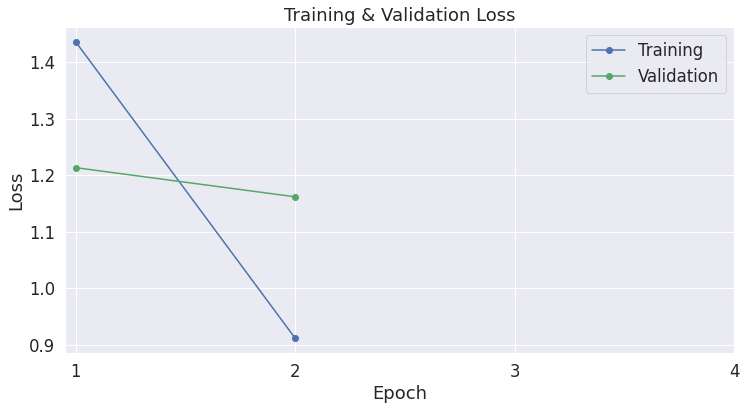

In [17]:
bc = BertClassification(25)
bc.train(train_dataloader, validation_dataloader, 2)
# Get all of the model's parameters as a list of tuples.
params = list(bc.model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=bc.training_stats)
df_stats = df_stats.set_index('epoch')

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.show()


In [39]:
# # Predict

input_ids = []
attention_masks = []

# For every sentence...
for sent in x_test:
    encoded_dict = tokenizer.encode_plus(
        sent,  # Sentence to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=50,  # Pad & truncate all sentences.
        pad_to_max_length=True,
        return_attention_mask=True,  # Construct attn. masks.
        return_tensors='pt',  # Return pytorch tensors.
    )
    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
# labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, torch.tensor(y_test))
# prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

bc.predict(prediction_dataloader)

prediction_label = []
for p in bc.predictions:
    prediction_label.extend(p.argmax(axis=1))

f1_score(y_test, prediction_label, average='weighted')

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Predicting labels for 4,750 test sentences...
    DONE.


TypeError: ignored

In [ ]:
accuracy_score(y_test, prediction_label)

In [ ]:
from sklearn.metrics import precision_score
precision_score(y_test, prediction_label, average='weighted')

In [40]:

# test_sent = "eating dinner with a friend's family, family leaves for a few minutes"
# test_sent = "at a sleepover in a friend's house first one to wake up"
test_sent = "i am not angry i'm happiness challenged"
encoded_dict = tokenizer.encode_plus(
        test_sent,  # Sentence to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=50,  # Pad & truncate all sentences.
        pad_to_max_length=True,
        return_attention_mask=True,  # Construct attn. masks.
        return_tensors='pt',  # Return pytorch tensors.
    )
test_single = TensorDataset(torch.cat([encoded_dict['input_ids']], dim=0),torch.cat([encoded_dict['attention_mask']], dim=0),torch.tensor([1]))
loader_data = DataLoader(test_single)
bc.predict(loader_data)
prediction_label = []
for p in bc.predictions:
    print(templates_map_reverse[p.argmax(axis=1)[0]])

0.6381052631578947

In [42]:
from sklearn.metrics import precision_score
precision_score(y_test, prediction_label, average='weighted')

0.645603938097743

In [35]:

# test_sent = "eating dinner with a friend's family, family leaves for a few minutes"
# test_sent = "at a sleepover in a friend's house first one to wake up"
test_sent = "i am not angry i'm happiness challenged"
encoded_dict = tokenizer.encode_plus(
        test_sent,  # Sentence to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=50,  # Pad & truncate all sentences.
        pad_to_max_length=True,
        return_attention_mask=True,  # Construct attn. masks.
        return_tensors='pt',  # Return pytorch tensors.
    )
test_single = TensorDataset(torch.cat([encoded_dict['input_ids']], dim=0),torch.cat([encoded_dict['attention_mask']], dim=0),torch.tensor([1]))
loader_data = DataLoader(test_single)
bc.predict(loader_data)
prediction_label = []
for p in bc.predictions:
    print(templates_map_reverse[p.argmax(axis=1)[0]])

Predicting labels for 4,750 test sentences...
    DONE.
Grumpy Cat 2


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [36]:
print(len(selected))

20
